# Assignment 1 — Descriptive Analysis of District-Level Structural Data (EU 2024)

**Group:** Linus Wössner, Alens Laskov, Jingyang Zhao  
**Course:** Internet & Database Technology  
**Dataset:** Official structural indicators at district level from Statistische Ämter des Bundes und der Länder
**File:** `data/ew24_structure_data.xlsx`

## Objective
Conduct a **thorough descriptive analysis** at the **district** level. We will quantify and visualize key structural patterns (e.g., demographics, labor market, education) and present an interpretable narrative of differences across districts.

## Evaluation Criteria (what we optimize for)
- **Completeness & executability** of the code (end-to-end, reproducible)
- **Efficiency** (avoid unnecessary loops; leverage pandas/numpy)
- **Robustness** (handle missingness/edge cases; clear checks)
- **Comments & explanations** (state *why*, not only *what*)
- **Structure of the notebook** (logical flow)
- **Line of argumentation** (coherent story, not a plot dump)

## Analysis Roadmap  

Our approach is designed to move from *raw data* to a *clear and well-argued descriptive analysis*.  
The sequence of steps reflects both best practice in data science.

1. **Data Understanding (Sanity Checks)**  
   - *Rationale:* Before producing any statistics, we must first confirm what the dataset contains. This ensures we do not interpret misleading results caused by hidden issues such as incorrect data types, duplicates, or missing values.  
   - *Story:* This step answers the question, *“Do we understand what we are analyzing?”* It builds trust in the dataset as the foundation of all later analysis.  

2. **Data Preparation (Ensuring Reliability)**  
   - *Rationale:* A dataset may look complete at first sight, but it often hides inconsistencies (percentages stored as text, inconsistent units, uneven missingness). Converting and standardizing variables creates a reliable analytical base.  
   - *Story:* This step transforms raw input into a dataset that is both technically usable and substantively meaningful, ensuring our descriptive statistics are valid.  

3. **Descriptive Analysis (Statistical Summaries, Visualizations & Analytical Narrative)**  
   - *Rationale:* Descriptive statistics quantify the distribution of each variable, while visualizations reveal patterns that tables alone may miss. Both are necessary for a thorough analysis. Numbers and charts only become valuable when interpreted. We highlight the most important structural differences across districts and examine which variables tend to move together.   
   - *Story:* Here we shift from “data quality” to “what the data tells us.” We explore central tendencies, variation, and relationships across districts. We then move from *“what the numbers are”* to *“what they mean in context.”*     
   
5. **Conclusion (Key Takeaways)**  
   - *Rationale:* A final synthesis condenses the analysis into a few clear, evidence-based insights. This provides closure and makes our work accessible for readers who may not follow every technical detail.  
   - *Story:* The analysis ends with a concise answer to the guiding question: *“What do the structural data tell us about German districts ahead of the 2024 European election?”*  

# Step 1 — Data Understanding

To ensure that our descriptive analysis is both **robust and interpretable**, we first examine the dataset for structural and quality issues.  
As the assignment requires a *thorough descriptive analysis*, this step verifies whether the raw data is suitable for statistical summaries and highlights areas that may require preparation.   

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io, requests

# --- Google Sheet settings ---
SHEET_ID = "1cUw9MoOr1mBr9xEUaA1CLHAv2uh_yw9j"
EXPORT_URL = f"https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=xlsx&id={SHEET_ID}"

# --- Download and load into pandas ---
resp = requests.get(EXPORT_URL)
resp.raise_for_status()  # will throw error if the sheet isn't shared for viewing

idt_df = pd.read_excel(io.BytesIO(resp.content), dtype={'District': str})

# 1. Check basic dataset information
print("\nDataset Information:")
idt_df.info()

print("\nFirst 5 rows:")
print(idt_df.head())

# 2. Check for duplicate rows
duplicates = idt_df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441 entries, 0 to 440
Data columns (total 52 columns):
 #   Column                                                                                                                               Non-Null Count  Dtype  
---  ------                                                                                                                               --------------  -----  
 0   Land                                                                                                                                 441 non-null    object 
 1   District                                                                                                                             441 non-null    object 
 2   Name                                                                                                                                 441 non-null    object 
 3   Municipalities                                            

## Step 1 — Data Understanding — Conclusion

1. **Structure**  
   - The dataset contains **444 rows** and **52 columns**.  
   - According to the Federal Returning Officer, Germany comprises **294 rural districts (Landkreise)** and **106 urban districts (kreisfreie Städte)**, for a total of **400 administrative districts** (2024).  
   - Since the dataset contains more rows than the official number of districts, those additional entries will need to be removed to restrict the analysis to the correct unit of analysis: the **district**.  

2. **Data types**  
   - Most variables are numeric as expected, but 10 appear as `object` despite some containing numeric information (e.g., `Area in km2`).  
   - These variables will need to be converted into proper numeric formats in the preparation step to allow statistical analysis.  

3. **Missingness**  
   - All variables appear to be missing 3 values (i.e., 441 non-Null).  
   - Further analysis is required to determine whether missingness is systematic (the same rows across multiple variables) or random.  

4. **Duplicates**  
   - *1* duplicate rows was found.  
   - We need to check whether these represent data entry errors or legitimate repeated values.  

**Conclusion:**  
The dataset is structurally sound for descriptive analysis at the district level, but rows outside the official set of 400 districts and those variables stored as objects that should be numeric will need to be addressed in the preparation step. This ensures our analysis is both robust and restricted to the appropriate unit of analysis.

**Note on Data Reliability:**  
The dataset is considered reliable as it originates from the *Statistische Ämter des Bundes und der Länder* (Germany’s official statistical offices).  
As part of the European Statistical System (ESS), this data falls under the **European Statistics Code of Practice** (Eurostat, 2017), which ensures that official statistics meet high standards of accuracy, comparability, and quality assurance.  
While our own checks are still necessary to confirm consistency and interpretability, this institutional framework provides an additional layer of trust in the dataset.

Having completed these sanity checks, we can now move on to **Step - 2 Data Preparation**, where we will address issues such as removing non-district rows, handling missing values, and converting data types to prepare the dataset for descriptive analysis.

## Step 2 — Data Preparation  

The purpose of this step is to transform the raw dataset into a format suitable for descriptive analysis at the district level, in line with the assignment requirements.  
Although the dataset originates from an official and reliable source, our initial sanity checks revealed structural issues that must be resolved before any statistics can be computed.  

In particular, the dataset currently contains more than the official number of districts in Germany.  
Before any cleaning or transformation can be applied, the dataset must therefore be reduced to exactly these 400 districts.  
This step ensures that the subsequent analysis is based on the correct unit of observation.  

The key preparation tasks are as follows:  

1. **Restricting the dataset to districts**  
   - Remove rows that do not represent individual districts (e.g., `"Deutschland"` totals or other non-district entries).  
   - This reduction guarantees that the dataset is aligned with the official count of 400 districts.  

2. **Data type corrections**  
   - Convert variables currently stored as `object` into numeric types where appropriate.  
   - Ensure categorical variables such as `Land` remain categorical for grouping and comparison.  

3. **Standardizing percentage-like variables**  
   - Ensure all percentage variables are expressed on a uniform scale (0–100) to allow meaningful comparison across districts.    

## 2.1 Restricting the dataset to districts


Distribution of District name lengths:
district_length
2     41
5    400
Name: count, dtype: int64

Mean length: 4.72
Median length: 5.0
Most common length: 5


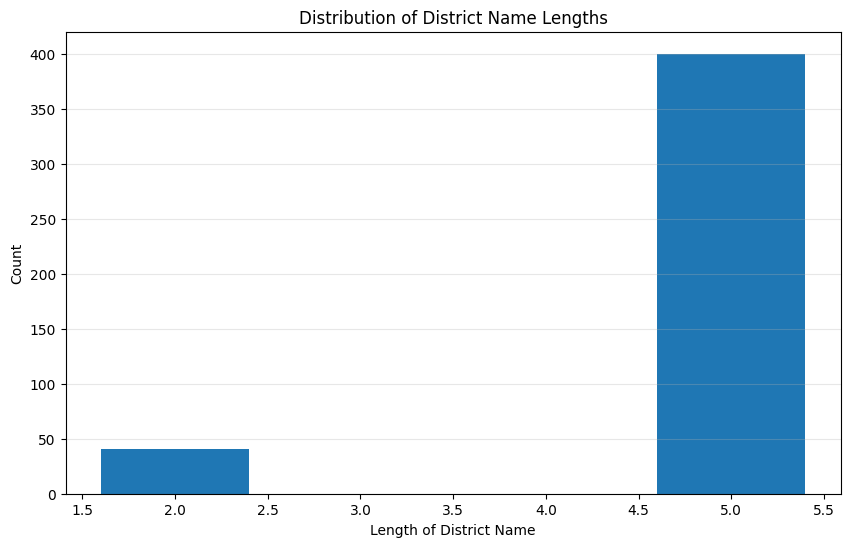


Number of rows with unusual District lengths: 41

Sample of rows with unusual District lengths:
    District  district_length
15        01                2
16        01                2
17        01                2
64        03                2
65        03                2
66        03                2
69        04                2
123       05                2
124       05                2
125       05                2


In [6]:
# Analyze the length of values in the 'District' column
if 'District' in idt_df.columns:
    # Create a new column with the length of each District value
    idt_df['district_length'] = idt_df['District'].astype(str).apply(len)

    # Get the distribution of lengths
    length_counts = idt_df['district_length'].value_counts().sort_index()

    print("\nDistribution of District name lengths:")
    print(length_counts)

    # Calculate statistics
    mean_length = idt_df['district_length'].mean()
    median_length = idt_df['district_length'].median()
    mode_length = idt_df['district_length'].mode()[0]

    print(f"\nMean length: {mean_length:.2f}")
    print(f"Median length: {median_length}")
    print(f"Most common length: {mode_length}")

    # Visualize the distribution
    plt.figure(figsize=(10, 6))
    plt.bar(length_counts.index, length_counts.values)
    plt.xlabel('Length of District Name')
    plt.ylabel('Count')
    plt.title('Distribution of District Name Lengths')
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    # Identify rows with unusual lengths (you can adjust the threshold)
    # Let's say we consider lengths that differ from the mode by more than 2 as unusual
    unusual_length_threshold = 1
    unusual_lengths = idt_df[abs(idt_df['district_length'] - mode_length) > unusual_length_threshold]

    print(f"\nNumber of rows with unusual District lengths: {len(unusual_lengths)}")

    if len(unusual_lengths) > 0:
        print("\nSample of rows with unusual District lengths:")
        print(unusual_lengths[['District', 'district_length']].head(10))

        # Code to drop these rows (commented out - uncomment when ready to use)
        # normal_length_df = idt_df[abs(idt_df['district_length'] - mode_length) <= unusual_length_threshold]
        # print(f"\nRemaining rows after dropping unusual lengths: {len(normal_length_df)}")


##### To ensure that our analysis is restricted to valid districts, we examined the length of the district identifiers.  
Rows with identifiers shorter than 5 characters do not correspond to official districts and were therefore removed.  
For the assignment, we retain only those districts with identifiers of **5 characters in length**, which together account for the official total of 400 districts.  


In [7]:
# Remove rows with District length shorter than 5
dist_df = idt_df[idt_df['district_length'] >= 5].copy()

# Print summary of the filtering
print(f"Original DataFrame: {len(idt_df)} rows")
print(f"Filtered DataFrame: {len(dist_df)} rows")
print(f"Removed {len(idt_df) - len(dist_df)} rows with District length < 5")

# Check the distribution of district lengths in the filtered DataFrame
length_counts = dist_df['district_length'].value_counts().sort_index()
print("\nDistrict length distribution in district-only DataFrame:")
print(length_counts)

# Optional: Reset the index of the new DataFrame
dist_df.reset_index(drop=True, inplace=True)

# Display a sample of the filtered DataFrame
print("\nSample of filtered DataFrame:")
display(dist_df.head())

Original DataFrame: 441 rows
Filtered DataFrame: 400 rows
Removed 41 rows with District length < 5

District length distribution in district-only DataFrame:
district_length
5    400
Name: count, dtype: int64

Sample of filtered DataFrame:


,Land,District,Name,Municipalities,Area in km2,Population on 31.12.2022 - Total (in 1000),Population on 31.12.2022 - German (in 1000),Population on 31.12.2022 - Foreigners (%),Population density on 31.12.2022 (inhabitants per km2),Increase (+) or decrease (-) in population in 2022 - Birth balance (per 1000 inhabitants),...,"Social insurance contributions as of 30.06.2023 - Other service providers and ""unspecified"" (%)",Recipients of benefits under SGB II in August 2023 - total (per 1000 inhabitants),Recipients of benefits under SGB II in August 2023 - Non-working individuals in need (%),Recipients of benefits under SGB II in August 2023 - Foreigners (%),Unemployment rate in October 2023 - Total,Unemployment rate in October 2023 - Men,Unemployment rate in October 2023 - Women,Unemployment rate in October 2023 - 15 to 24 years,Unemployment rate in October 2023 - 55 to 64 years,district_length
0,Schleswig-Holstein,01001,"Flensburg, Stadt",1,56.7,92.6,75.5,18.5,1631.4,-4.2,...,40.0,115.1,25.3,37.9,7.8,8.4,7.0,6.0,7.5,5
1,Schleswig-Holstein,01002,"Kiel, Landeshauptstadt",1,118.7,247.7,214.1,13.6,2087.8,-2.9,...,39.8,120.5,26.1,41.0,7.5,7.9,7.1,5.3,7.9,5
2,Schleswig-Holstein,01003,"Lübeck, Hansestadt",1,214.2,218.1,190.8,12.5,1018.2,-6.7,...,32.5,104.9,25.7,35.9,7.6,8.1,7.1,6.6,7.6,5
3,Schleswig-Holstein,01004,"Neumünster, Stadt",1,71.7,79.5,68.3,14.2,1109.4,-7.1,...,26.6,112.0,26.3,35.6,8.2,8.4,8.0,8.0,7.6,5
4,Schleswig-Holstein,01051,Dithmarschen,116,1428.2,135.3,124.8,7.8,94.7,-7.6,...,32.3,74.6,26.9,35.2,5.5,5.8,5.2,5.8,5.2,5


## 2.2 Data type corrections
The next step in the preparation process is to convert variables that are currently stored as `object` into proper numeric formats.  
Although these variables contain numeric information, they are not usable for calculations until transformed into numeric types.  
Once the conversions are completed, we will re-check the dataset for **missing values** and **duplicates** to ensure that the data is consistent and ready for descriptive analysis.  


In [8]:
# List of column indices to convert to numeric (float)
columns_to_convert = [4, 28, 33, 39, 40, 41, 42]

# Get the actual column names from the indices
columns_to_convert_names = dist_df.columns[columns_to_convert].tolist()

# Print the columns we're converting
print("Converting the following columns to numeric (float):")
for idx, col_name in zip(columns_to_convert, columns_to_convert_names):
    print(f"Index {idx}: {col_name}")

# Convert each column to numeric
for col in columns_to_convert_names:
    # Store original data type for reporting
    original_dtype = dist_df[col].dtype

    # Convert to numeric, coercing errors to NaN
    dist_df[col] = pd.to_numeric(dist_df[col], errors='coerce')

    # Report conversion results
    new_dtype = dist_df[col].dtype
    nan_count = dist_df[col].isna().sum()
    print(f"Converted '{col}' from {original_dtype} to {new_dtype} ({nan_count} NaN values)")

# Remove the district_length column
if 'district_length' in dist_df.columns:
    print("\nRemoving 'district_length' column...")
    dist_df.drop('district_length', axis=1, inplace=True)
    print("'district_length' column removed successfully")
else:
    print("\n'district_length' column not found in the DataFrame")

# Display summary of the DataFrame with converted columns and removed district_length
print("\nDataFrame summary after modifications:")
print(dist_df.info())

# Show a sample of the converted data
print("\nSample of DataFrame with converted columns:")
display(dist_df[columns_to_convert_names].head())

Converting the following columns to numeric (float):
Index 4: Area in km2
Index 28: School graduates from vocational schools 2022 (per 1000 inhabitants)
Index 33: School graduates from general education schools 2022 - with general or subject-specific higher education entrance qualification (%)
Index 39: Social insurance contributions as of 30.06.2023 - Agriculture, forestry, fishing (%)
Index 40: Social insurance contributions as of 30.06.2023 - Manufacturing industry (%)
Index 41: Social insurance contributions as of 30.06.2023 - Trade, hospitality, transport (%)
Index 42: Social insurance contributions as of 30.06.2023 - Public and private service providers (%)
Converted 'Area in km2' from float64 to float64 (0 NaN values)
Converted 'School graduates from vocational schools 2022 (per 1000 inhabitants)' from object to float64 (5 NaN values)
Converted 'School graduates from general education schools 2022 - with general or subject-specific higher education entrance qualification (%)' fr

,Area in km2,School graduates from vocational schools 2022 (per 1000 inhabitants),School graduates from general education schools 2022 - with general or subject-specific higher education entrance qualification (%),"Social insurance contributions as of 30.06.2023 - Agriculture, forestry, fishing (%)",Social insurance contributions as of 30.06.2023 - Manufacturing industry (%),"Social insurance contributions as of 30.06.2023 - Trade, hospitality, transport (%)",Social insurance contributions as of 30.06.2023 - Public and private service providers (%)
0,56.7,8.0,43.9,NaN,NaN,25.4,19.2
1,118.7,5.6,44.0,NaN,NaN,19.1,25.6
2,214.2,4.0,39.0,0.1,23.6,23.1,20.7
3,71.7,7.8,43.3,0.8,19.8,31.5,21.3
4,1428.2,2.2,28.4,4.1,24.8,27.5,11.3


After converting object columns to numeric formats, several variables now contain missing values (`NaN`).  
These missing entries arise because some cells contained symbols or non-numeric placeholders that could not be parsed during conversion.  
Although these values were not visible as missing in the raw dataset, they would have distorted any statistical calculations.  
It is therefore preferable to represent them explicitly as missing values.  

In practice, datasets rarely have complete coverage across all variables, and part of descriptive analysis is to acknowledge and handle this missingness transparently.  
At a later stage, we will decide on an appropriate strategy for dealing with these cases (e.g., retaining, imputing, or excluding variables with extensive missing data).

In [9]:
# Get the total number of rows in the DataFrame
total_rows = len(dist_df)
print(f"Total rows in dist_df: {total_rows}")

# Get count of non-null values for each column
non_null_counts = dist_df.count()

# Find columns where non-null count is not equal to the total number of rows (400)
incomplete_columns = non_null_counts[non_null_counts != total_rows]

# Display results
print(f"\nFound {len(incomplete_columns)} columns with non-null count != {total_rows}:")
print("\nColumns with missing values:")
for col_name, count in incomplete_columns.items():
    missing_count = total_rows - count
    missing_percent = (missing_count / total_rows) * 100
    print(f"  {col_name}: {missing_count} missing values ({missing_percent:.2f}%)")

# Create a summary DataFrame for better visualization
missing_summary = pd.DataFrame({
    'Column': incomplete_columns.index,
    'Non-null Count': incomplete_columns.values,
    'Missing Count': total_rows - incomplete_columns.values,
    'Missing Percentage': ((total_rows - incomplete_columns.values) / total_rows * 100).round(2)
}).sort_values('Missing Count', ascending=False)

print("\nSummary of columns with missing values (sorted by most missing):")
display(missing_summary)

Total rows in dist_df: 400

Found 6 columns with non-null count != 400:

Columns with missing values:
  School graduates from vocational schools 2022 (per 1000 inhabitants): 5 missing values (1.25%)
  School graduates from general education schools 2022 - with general or subject-specific higher education entrance qualification (%): 2 missing values (0.50%)
  Social insurance contributions as of 30.06.2023 - Agriculture, forestry, fishing (%): 20 missing values (5.00%)
  Social insurance contributions as of 30.06.2023 - Manufacturing industry (%): 10 missing values (2.50%)
  Social insurance contributions as of 30.06.2023 - Trade, hospitality, transport (%): 2 missing values (0.50%)
  Social insurance contributions as of 30.06.2023 - Public and private service providers (%): 8 missing values (2.00%)

Summary of columns with missing values (sorted by most missing):


,Column,Non-null Count,Missing Count,Missing Percentage
2,Social insurance contributions as of 30.06.202...,380,20,5.00
3,Social insurance contributions as of 30.06.202...,390,10,2.50
5,Social insurance contributions as of 30.06.202...,392,8,2.00
0,School graduates from vocational schools 2022 ...,395,5,1.25
1,School graduates from general education school...,398,2,0.50
4,Social insurance contributions as of 30.06.202...,398,2,0.50


## 2.3 Standardizing percentage-like variables

Several variables in the dataset are recorded as percentages.  
However, these values are not always represented on a uniform scale.  

To ensure comparability across all districts, it is necessary to bring these variables onto a **consistent 0–100 scale**.  
This step prevents distortions in summary statistics and visualizations, and ensures that differences between districts reflect true variation rather than inconsistent data formatting.  

By standardizing percentage-like variables, we create a dataset where all proportions can be interpreted consistently as percentages out of 100.  
This adjustment prepares the data for accurate descriptive analysis in the next step.


In [10]:
# Define the specific columns to process
columns_to_process = [7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 25, 30, 31, 32, 33, 39]

# Create an empty DataFrame to store standardization statistics
stats_df = pd.DataFrame(columns=[
    'Column', 'Original_Min', 'Original_Max', 'Original_Mean',
    'Standardized_Min', 'Standardized_Max', 'Standardized_Mean', 'Conversion_Applied'
])

# Process each specified column
for col_idx in columns_to_process:
    # Get the column name (using dist_df as the DataFrame)
    col = dist_df.columns[col_idx]

    # Get original statistics
    orig_min = dist_df[col].min()
    orig_max = dist_df[col].max()
    orig_mean = dist_df[col].mean()

    # Default conversion message
    conversion_applied = "No conversion needed (already in 0-100 range)"

    # Check if values are in decimal form (0-1 range)
    if orig_max <= 1.0 and orig_min >= 0:
        dist_df[col] = dist_df[col] * 100
        conversion_applied = "Multiplied by 100 (0-1 to 0-100)"

    # Check if values are in a different range that needs normalization
    elif orig_max > 100 or orig_min < 0:
        # Normalize to 0-100 scale
        min_val = dist_df[col].min()
        max_val = dist_df[col].max()
        dist_df[col] = ((dist_df[col] - min_val) / (max_val - min_val)) * 100
        conversion_appl
        ied = f"Normalized from [{min_val:.2f}-{max_val:.2f}] to [0-100]"

    # Get new statistics after conversion
    new_min = dist_df[col].min()
    new_max = dist_df[col].max()
    new_mean = dist_df[col].mean()

    # Create a new row as a dictionary
    new_row_dict = {
        'Column': col,
        'Original_Min': orig_min,
        'Original_Max': orig_max,
        'Original_Mean': orig_mean,
        'Standardized_Min': new_min,
        'Standardized_Max': new_max,
        'Standardized_Mean': new_mean,
        'Conversion_Applied': conversion_applied
    }

    # Add the new row at a specific index using loc
    stats_df.loc[len(stats_df)] = new_row_dict

# Display the standardization results
print("\nStandardization Results:")
display(stats_df)


Standardization Results:


,Column,Original_Min,Original_Max,Original_Mean,Standardized_Min,Standardized_Max,Standardized_Mean,Conversion_Applied
0,Population on 31.12.2022 - Foreigners (%),3.5,39.0,12.947000,3.5,39.0,12.947000,No conversion needed (already in 0-100 range)
1,Age on 31.12.2022 - under 16 years (%),11.5,18.0,14.882250,11.5,18.0,14.882250,No conversion needed (already in 0-100 range)
2,Age on 31.12.2022 - 16-17 years (%),1.3,2.3,1.827000,1.3,2.3,1.827000,No conversion needed (already in 0-100 range)
3,Age on 31.12.2022 - 18-24 years (%),4.4,13.4,7.124500,4.4,13.4,7.124500,No conversion needed (already in 0-100 range)
4,Age on 31.12.2022 - 25-34 years (%),6.5,20.0,11.818250,6.5,20.0,11.818250,No conversion needed (already in 0-100 range)
5,Age on 31.12.2022 - 35-59 years (%),29.2,36.8,33.605000,29.2,36.8,33.605000,No conversion needed (already in 0-100 range)
6,Age on 31.12.2022 - 60-74 years (%),13.1,26.2,19.445250,13.1,26.2,19.445250,No conversion needed (already in 0-100 range)
7,Age on 31.12.2022 - 75 years and over (%),7.7,17.3,11.296250,7.7,17.3,11.296250,No conversion needed (already in 0-100 range)
8,Land area by type of actual use on 31.12.2021 ...,5.5,75.4,22.132500,5.5,75.4,22.132500,No conversion needed (already in 0-100 range)
9,Land area by type of actual use on 31.12.2021 ...,24.6,94.5,77.867500,24.6,94.5,77.867500,No conversion needed (already in 0-100 range)


The diagnostic check for percentage-like variables revealed that no conversion was required — all relevant variables were already consistently expressed on a 0–100 scale.  

## Step 2 — Data Preparation — Conclusion

The data preparation phase is now complete.  

Through this process, we:  
1. restricted the dataset to the **400 valid districts**,  
2. converted variables stored as `object` into proper numeric types while keeping categorical variables consistent,  
3. checked percentage-like variables and confirmed that all were already expressed on a uniform 0–100 scale.  

As a result, the dataset is structurally consistent, analytically robust, and fully aligned with the **district-level unit of analysis** required for this assignment.  
We are now ready to proceed to **Step 3 — Descriptive Analysis**, where we will explore and interpret structural patterns across German districts.


## Step 3 — Descriptive Analysis  

With the dataset now cleaned and restricted to the 400 valid districts, we proceed to the descriptive analysis of the structural indicators.  
  
Rather than examining all 52 available variables in detail, we focus on a **core set of indicators** that political science research has consistently highlighted as important drivers of electoral outcomes.  
This approach ensures that the analysis is both thorough and interpretable, while remaining grounded in theoretical expectations.  

The following five indicators are selected for detailed descriptive analysis:  

1. **Population Density**   
   - Higher-density districts are more likely to support progressive parties (SPD, Greens), while rural districts tend to favor conservative or populist parties (CDU/CSU, AfD).  
   - *Reference: Haffert & Mitteregger (2023).*  

2. **Share of Foreign Residents**  
   - The presence of foreigners has been shown to shape electoral preferences.  
   - Districts with higher foreign population shares often exhibit lower support for far-right parties, while homogeneous regions show stronger AfD support.  
   - *References: Kellermann & Winter (2021); Otto & Steinhardt (2014).*  

3. **Disposable Income per Inhabitant**  
   - Income levels are a consistent predictor of electoral behavior.  
   - Higher-income districts tend to support incumbents and pro-market parties, while lower-income or more unequal regions lean toward protest or extremist parties.  
   - *References: Batool (2008); Batool & Sieg (2009); Dorn et al. (2018).*  

4. **Recipients of Social Welfare (SGB II)**  
   - Welfare dependency is a central political cleavage in Germany.  
   - Higher levels of SGB II receipt correlate with stronger support for left-leaning parties, while welfare debates have historically fractured the SPD and boosted Die Linke and AfD.  
   - *References: Hohmeyer & Lietzmann (2019); Dostal (2017).*   

**5. Business Activity**  
- The density of companies per capita reflects levels of entrepreneurship, service-sector development, and local economic dynamism.  
- Districts with stronger business activity are associated with progressive and pro-market parties (SPD, Greens, FDP), while structurally weaker or post-industrial regions with fewer companies per capita align more with conservative or populist parties (CDU/CSU, AfD).  
- *References: Kowalewski (2010, 2011).*  
  

By structuring the descriptive analysis around these five theoretically motivated indicators, we ensure that our work goes beyond simple summary statistics.  
Instead, we produce a **narrative of structural divides** that links the data back to established research on electoral behavior in Germany.  

## 3.1 Population Density  

We begin by examining the distribution of inhabitants per km² across districts.  
Population density captures the urban–rural divide, which research identifies as a central structural cleavage in German politics (Haffert & Mitteregger, 2023)
This indicator allows us to describe how strongly districts differ in their degree of urbanization and sets the stage for regional comparisons in later steps.  

Summary statistics for Population density on 31.12.2022 (inhabitants per km2)
count     400.00
mean      544.08
std       719.26
min        35.60
25%       117.98
50%       204.50
75%       686.48
max      4868.00
Name: Population density on 31.12.2022 (inhabitants per km2), dtype: float64


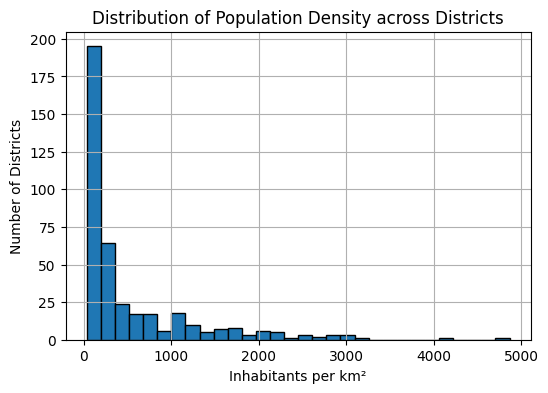

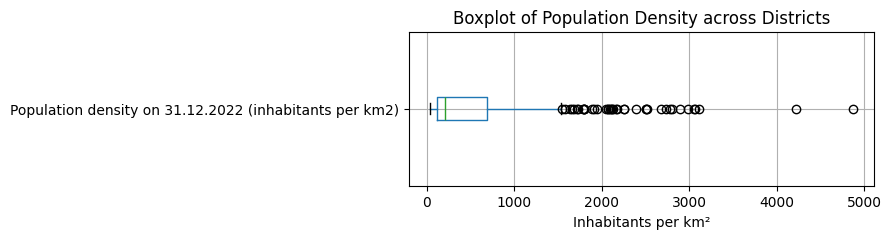


Top 5 districts by population density:
                          Name  \
223  München, Landeshauptstadt   
324              Berlin, Stadt   
117   Frankfurt am Main, Stadt   
108               Herne, Stadt   
178      Stuttgart, Stadtkreis   

     Population density on 31.12.2022 (inhabitants per km2)  
223                                             4868.0       
324                                             4214.1       
117                                             3113.3       
108                                             3060.4       
178                                             3052.5       

Bottom 5 districts by population density:
                       Name  \
339                Prignitz   
367  Altmarkkreis Salzwedel   
342               Uckermark   
337      Ostprignitz-Ruppin   
36        Lüchow-Dannenberg   

     Population density on 31.12.2022 (inhabitants per km2)  
339                                               35.6       
367                          

In [11]:
# Column names
col = "Population density on 31.12.2022 (inhabitants per km2)"
label_col = "District"
name_col = "Name"  # The column containing district names

# 1) Summary statistics
print("Summary statistics for", col)
print(dist_df[col].describe().round(2))

# 2) Histogram
plt.figure(figsize=(6,4))
dist_df[col].hist(bins=30, edgecolor="black")
plt.title("Distribution of Population Density across Districts")
plt.xlabel("Inhabitants per km²")
plt.ylabel("Number of Districts")
plt.show()

# 3) Boxplot
plt.figure(figsize=(6,2))
dist_df.boxplot(column=col, vert=False)
plt.title("Boxplot of Population Density across Districts")
plt.xlabel("Inhabitants per km²")
plt.show()

# 4) Top 5 and Bottom 5 districts by population density - now showing names
print("\nTop 5 districts by population density:")
print(dist_df[[name_col, col]].sort_values(by=col, ascending=False).head(5))

print("\nBottom 5 districts by population density:")
print(dist_df[[name_col, col]].sort_values(by=col, ascending=True).head(5))

## **3.1 Interpretation — Population Density**

The distribution is strongly right-skewed: the mean (≈ 544 inh./km²) is far above the median (≈ 205), with a long upper tail (max ≈ 4,868). Most districts cluster below ~700 (75th percentile ≈ 686), while a small set of highly urban districts drive the upper tail. This pattern is consistent with an urban–rural divide: many low-to-moderate density districts and few very dense urban centers. For subsequent comparisons (by Bundesland, urban/rural), we will keep in mind that standard statistics may be influenced by these high-density outliers.


## 3.2 Share of Foreign Residents

We now examine the share of foreign residents across districts.  
This indicator captures demographic diversity, which research highlights as a key factor in shaping electoral cleavages: higher foreign population shares are often associated with weaker far-right support, while more homogeneous districts show stronger AfD alignment (Kellermann & Winter, 2021; Otto & Steinhardt, 2014).  

Descriptive analysis allows us to identify how strongly districts differ in their foreign population shares and where concentrations of diversity occur.


Extracting ZIP ...
Extracted to: /content/maps
Reading shapefile: /content/maps/VG2500_KRS.shp
Shapefile rows: 400 | CRS: EPSG:31467

Summary stats for Population on 31.12.2022 - Foreigners (%)
count    400.00
mean      12.95
std        5.64
min        3.50
25%        8.60
50%       12.00
75%       16.40
max       39.00
Name: Population on 31.12.2022 - Foreigners (%), dtype: float64

Top 5 by Population on 31.12.2022 - Foreigners (%)
                             Name  Population on 31.12.2022 - Foreigners (%)
118      Offenbach am Main, Stadt                                       39.0
117      Frankfurt am Main, Stadt                                       30.9
199         Pforzheim, Stadtkreis                                       30.1
161  Ludwigshafen am Rhein, Stadt                                       29.7
184         Heilbronn, Stadtkreis                                       29.2

Bottom 5 by Population on 31.12.2022 - Foreigners (%)
                                 Name  \
352 

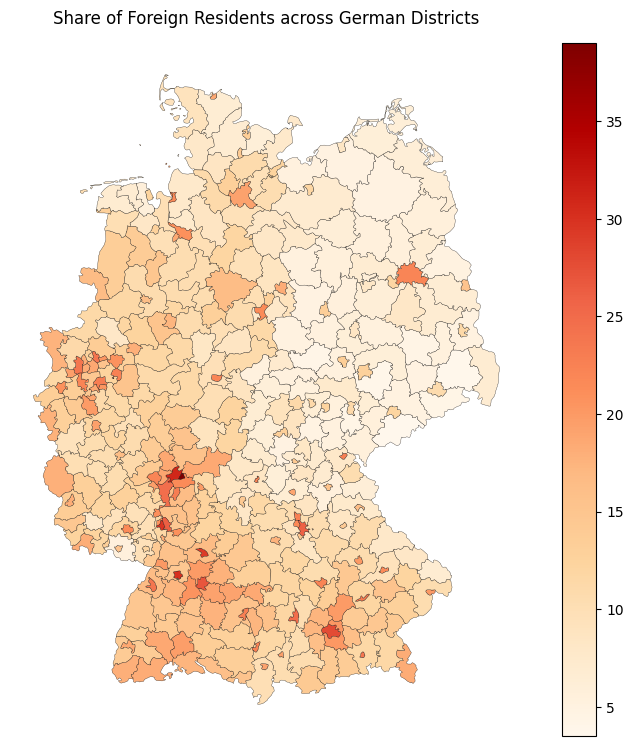

In [12]:
# ==============================
# Colab-ready: Drive ZIP -> Shapefile -> Merge -> Plot
# ==============================

# 0) Install geospatial deps (quietly)
try:
    import geopandas as gpd
except ImportError:
    !pip -q install geopandas shapely fiona pyproj

import os, io, zipfile, requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# ---------------------------
# A) Download ZIP from Google Drive (handles large files w/ confirm token)
FILE_ID = "11iGO7zV11UK45PWvchpgfxCvDqB2eVRA"  # <- from your link
SESSION = requests.Session()

def gdrive_download(file_id, dst_path):
    base = "https://drive.google.com/uc?export=download"
    r = SESSION.get(base, params={"id": file_id}, stream=True)
    # For large files Google adds a confirmation token; detect and retry
    token = None
    for k, v in r.cookies.items():
        if k.startswith("download_warning"):
            token = v
    if token:
        r = SESSION.get(base, params={"id": file_id, "confirm": token}, stream=True)
    r.raise_for_status()
    with open(dst_path, "wb") as f:
        for chunk in r.iter_content(32768):
            if chunk:
                f.write(chunk)

zip_path = "/content/maps.zip"
extract_dir = "/content/maps"
os.makedirs(extract_dir, exist_ok=True)

print("Downloading ZIP from Drive ...")
gdrive_download(FILE_ID, zip_path)

print("Extracting ZIP ...")
with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall(extract_dir)
print("Extracted to:", extract_dir)

# ---------------------------
# B) Find a .shp inside the extracted folder
def find_shp(root, preferred_base=None):
    shp_candidate = None
    for dirpath, _, files in os.walk(root):
        for fn in files:
            if fn.lower().endswith(".shp"):
                full = os.path.join(dirpath, fn)
                if preferred_base and fn.lower() == preferred_base.lower() + ".shp":
                    return full
                if shp_candidate is None:
                    shp_candidate = full
    return shp_candidate

# Prefer VG2500_KRS.shp if present
shp_path = find_shp(extract_dir, preferred_base="VG2500_KRS")
if shp_path is None:
    raise FileNotFoundError("No .shp found in the ZIP. Make sure the ZIP contains the full shapefile set.")

print("Reading shapefile:", shp_path)
districts = gpd.read_file(shp_path)
print("Shapefile rows:", len(districts), "| CRS:", districts.crs)

# ---------------------------
# C) Ensure we have dist_df (load from Google Sheet if missing)
if "dist_df" not in globals():
    # Put your Sheet ID here if needed
    SHEET_ID = "1cUw9MoOr1mBr9xEUaA1CLHAv2uh_yw9j"  # change if different
    XLSX_URL = f"https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=xlsx&id={SHEET_ID}"
    r = requests.get(XLSX_URL); r.raise_for_status()
    dist_df = pd.read_excel(io.BytesIO(r.content))
    print("Loaded dist_df from Google Sheets:", dist_df.shape)

# Normalize keys for merge
left_key  = "AGS"        # column in shapefile (adjust if different)
right_key = "District"   # column in your table

if left_key not in districts.columns:
    raise KeyError(f"'{left_key}' not in shapefile columns: {list(districts.columns)}")
if right_key not in dist_df.columns:
    raise KeyError(f"'{right_key}' not in dist_df columns: {list(dist_df.columns)}")

districts[left_key] = districts[left_key].astype(str).str.strip()
dist_df[right_key]  = dist_df[right_key].astype(str).str.strip()

# ---------------------------
# D) Quick stats (optional)
metric_col = "Population on 31.12.2022 - Foreigners (%)"
name_col   = "Name"

if metric_col in dist_df.columns:
    print("\nSummary stats for", metric_col)
    print(dist_df[metric_col].describe().round(2))

    if name_col in dist_df.columns:
        print("\nTop 5 by", metric_col)
        print(dist_df[[name_col, metric_col]].sort_values(metric_col, ascending=False).head(5))
        print("\nBottom 5 by", metric_col)
        print(dist_df[[name_col, metric_col]].sort_values(metric_col, ascending=True).head(5))

# ---------------------------
# E) Merge and plot
geo_df = districts.merge(dist_df, left_on=left_key, right_on=right_key, how="inner")
print("\nMerged rows:", len(geo_df))

value_col = metric_col  # change to any numeric column you want to map
if value_col in geo_df.columns:
    ax = geo_df.plot(
        column=value_col, cmap="OrRd", legend=True,
        figsize=(10, 9), edgecolor="black", linewidth=0.2,
        missing_kwds={"color": "lightgrey", "label": "No data"},
    )
    ax.set_title("Share of Foreign Residents across German Districts", pad=14)
    ax.set_axis_off()
    plt.show()
else:
    print(f"Column not found for choropleth: {value_col}")
    print("Available numeric columns:", geo_df.select_dtypes(include='number').columns.tolist())


**3.2 Interpretation — Share of Foreign Residents**

Across all 400 districts, the average share of foreign residents is about 13%, with a median of 12%. The distribution is moderately right-skewed: while most districts fall between 9% (25th percentile) and 16% (75th percentile), a small number of urban centers reach much higher values. Offenbach am Main (39%), Frankfurt am Main (31%), and Pforzheim (30%) are at the top end, confirming that large cities and industrial hubs attract the highest proportions of foreign residents.  

At the other end, several districts in Saxony and Saxony-Anhalt record very low shares, with Erzgebirgskreis and Bautzen below 4%. This indicates a clear regional divide: **western and southwestern urban districts are highly diverse, while rural eastern districts remain comparatively homogeneous**.  

The spatial distribution becomes particularly evident in the choropleth. High concentrations of foreign residents are visible in metropolitan areas along the Rhine-Main region, Baden-Württemberg, and Bavaria, while eastern Germany shows consistently low levels of foreign population.  

These findings align with previous research highlighting the uneven geographic distribution of demographic diversity in Germany and its relevance for electoral behavior: more diverse urban districts tend to exhibit weaker support for far-right parties, while more homogeneous regions, especially in the East, are more receptive to them (Kellermann & Winter, 2021; Otto & Steinhardt, 2014).


## 3.3 Disposable Income per Inhabitant  

Disposable income provides a direct measure of regional prosperity and is a well-established determinant of electoral behavior.  
Research shows that higher-income districts tend to support incumbents and pro-market parties (CDU/CSU, FDP), while poorer districts or those with high inequality are more inclined toward protest or extremist parties (SPD, Left, AfD) (Batool, 2008; Batool & Sieg, 2009; Dorn et al., 2018).  

By examining district-level disposable income, we can capture structural socio-economic divides across Germany.

In [13]:
!pip install seaborn

Summary statistics for Disposable income of private households in 2021 (EUR per inhabitant)
count      400.00
mean     24157.00
std       2373.18
min      17116.00
25%      22525.00
50%      24021.00
75%      25581.25
max      37515.00
Name: Disposable income of private households in 2021 (EUR per inhabitant), dtype: float64


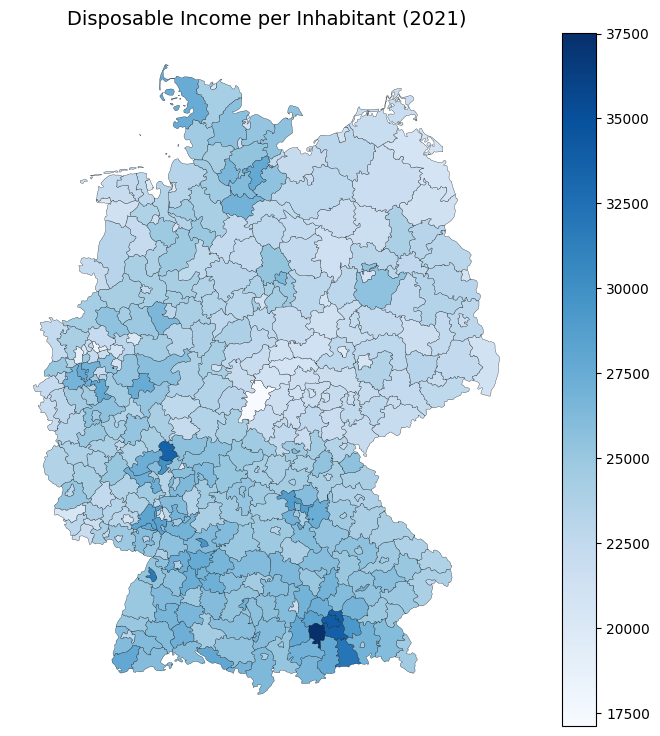

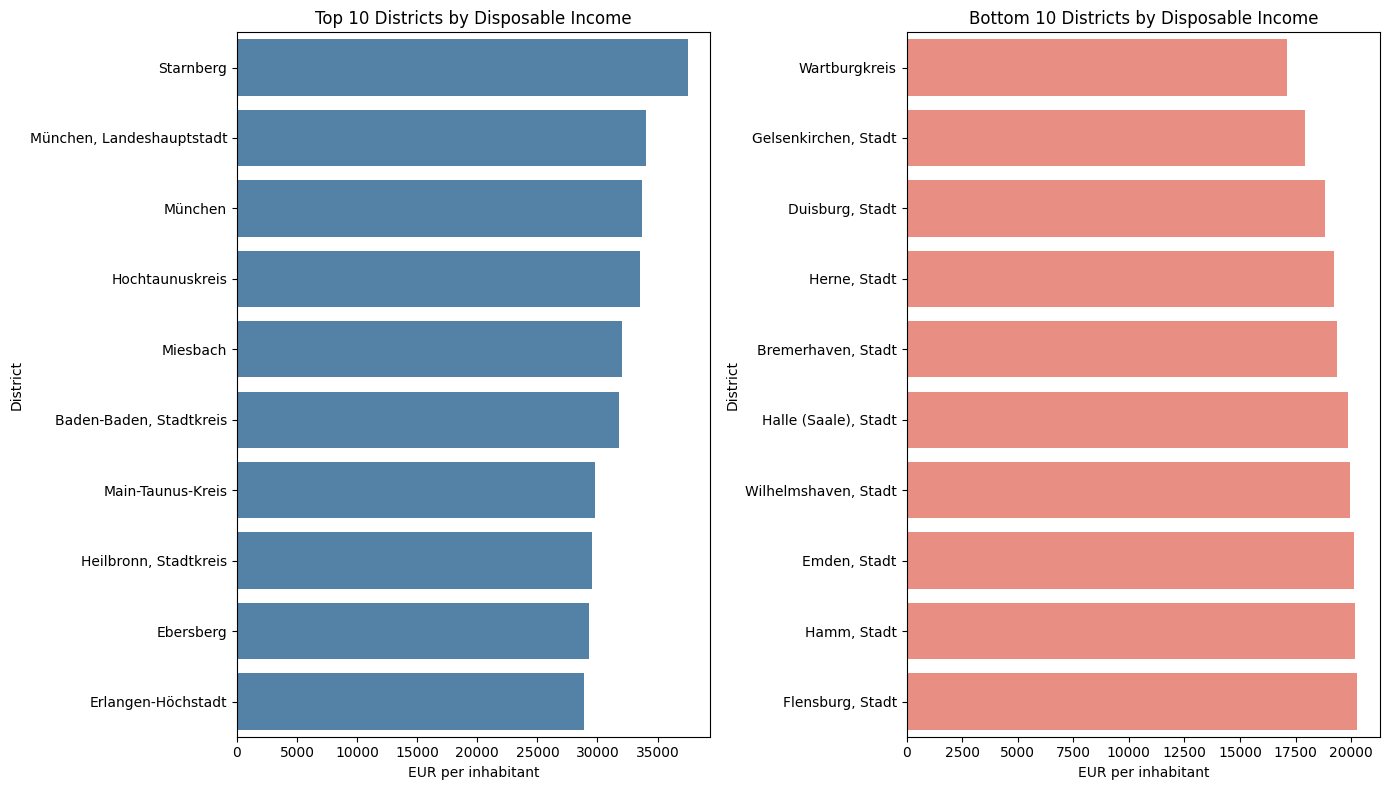

In [14]:
import seaborn as sns

# Column names
income_col = "Disposable income of private households in 2021 (EUR per inhabitant)"
label_col = "District"
name_col = "Name"

# 1) Summary statistics
print("Summary statistics for", income_col)
print(dist_df[income_col].describe().round(2))

# 2) Choropleth map
if income_col in geo_df.columns:
    ax = geo_df.plot(
        column=income_col,
        cmap="Blues",
        legend=True,
        figsize=(10, 9),
        edgecolor="black",
        linewidth=0.2,
        missing_kwds={"color": "lightgrey", "label": "No data"},
    )
    ax.set_title("Disposable Income per Inhabitant (2021)", fontsize=14)
    ax.set_axis_off()
    plt.show()
else:
    print(f"Column '{income_col}' not found in geo_df. Did you merge dist_df with shapefile?")

# 3) Ranked barplots (Top 10 & Bottom 10)

# Sort and keep top/bottom 10 by income
top10 = dist_df.nlargest(10, income_col)
bottom10 = dist_df.nsmallest(10, income_col)

fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharex=False)

# Top 10
sns.barplot(
    y="Name",
    x=income_col,
    data=top10,
    ax=axes[0],
    color="steelblue"
)
axes[0].set_title("Top 10 Districts by Disposable Income")
axes[0].set_xlabel("EUR per inhabitant")
axes[0].set_ylabel("District")

# Bottom 10
sns.barplot(
    y="Name",
    x=income_col,
    data=bottom10,
    ax=axes[1],
    color="salmon"
)
axes[1].set_title("Bottom 10 Districts by Disposable Income")
axes[1].set_xlabel("EUR per inhabitant")
axes[1].set_ylabel("District")

plt.tight_layout()
plt.show()

**3.3 Interpretation — Disposable Income per Inhabitant**

The average disposable income across districts is about €24,157 per inhabitant, with a median of €24,021. The distribution is moderately dispersed (std ≈ €2,373), ranging from a minimum of around €17,116 to a maximum of €37,515. The choropleth map highlights a clear spatial divide: higher incomes are concentrated in Bavaria (e.g., Munich, Starnberg) and prosperous regions around Frankfurt and Stuttgart, while lower incomes dominate parts of North Rhine-Westphalia, northern Germany, and the eastern states.  

The ranked barplots illustrate this contrast at the extremes. The wealthiest districts include Starnberg, Munich (city and surrounding areas), Hochtaunuskreis, and Baden-Baden, all exceeding €30,000 per inhabitant. At the other end, districts such as Gelsenkirchen, Duisburg, and Bremerhaven record incomes closer to €17,000–€19,000. This divergence underlines the persistence of structural inequalities between affluent metropolitan areas and struggling post-industrial regions.  

In terms of electoral relevance, research shows that higher-income districts tend to support incumbents and pro-market parties (CDU/CSU, FDP), while economically weaker or more unequal regions lean toward protest parties such as AfD or Die Linke (Batool, 2008; Batool & Sieg, 2009; Dorn et al., 2018). The descriptive findings here align with this literature: the high-income clusters in Bavaria and Baden-Württemberg are historically conservative strongholds, while low-income Ruhrgebiet cities and eastern districts overlap with areas of strong AfD or Left support.  

Thus, the variation in disposable income across districts not only reflects socio-economic disparities but also helps explain the electoral geography of Germany, where prosperity often sustains conservative or market-liberal dominance, while economic vulnerability fuels populist or left-wing alternatives.


## Urban Form vs Prosperity (hexbin).

Population density is a proxy for urban form and the agglomeration forces that cities generate. Economic geography suggests that denser districts benefit from thicker labor markets, greater firm diversity, and knowledge spillovers—mechanisms that can translate into higher disposable incomes. Yet this association can be muted or reversed by housing costs, legacy industry structure, or regional disparities (e.g., East–West patterns). Our hexbin plot relates population density (inh./km², 2022) to disposable income (EUR/inh., 2021) to test for an urban income premium and to see whether prosperity is concentrated in metropolitan areas or more evenly distributed. Hexbins reduce overplotting: a northeast concentration signals a positive density–income link, while a flat or dispersed cloud indicates weak coupling between urban form and prosperity.

In [15]:
# Define the columns used in the last two hexbin plots
columns_for_extraction = [
    "Population density on 31.12.2022 (inhabitants per km2)",
    "Disposable income of private households in 2021 (EUR per inhabitant)",
    "Population on 31.12.2022 - Foreigners (%)",
    "Business register 2021 - Total companies (per 1000 inhabitants)"
]

# Extract the data from the dist_df DataFrame
extracted_data = dist_df[columns_for_extraction]

# Display the first few rows of the extracted data
print("Sample of the extracted data:")
display(extracted_data.head())

# Display the information about the extracted data
print("\nInformation about the extracted data:")
extracted_data.info()

Sample of the extracted data:


,Population density on 31.12.2022 (inhabitants per km2),Disposable income of private households in 2021 (EUR per inhabitant),Population on 31.12.2022 - Foreigners (%),Business register 2021 - Total companies (per 1000 inhabitants)
0,1631.4,20282,18.5,36.7
1,2087.8,21320,13.6,34.6
2,1018.2,22418,12.5,36.5
3,1109.4,21167,14.2,36.6
4,94.7,24682,7.8,41.3



Information about the extracted data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   Population density on 31.12.2022 (inhabitants per km2)                400 non-null    float64
 1   Disposable income of private households in 2021 (EUR per inhabitant)  400 non-null    int64  
 2   Population on 31.12.2022 - Foreigners (%)                             400 non-null    float64
 3   Business register 2021 - Total companies (per 1000 inhabitants)       400 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 12.6 KB


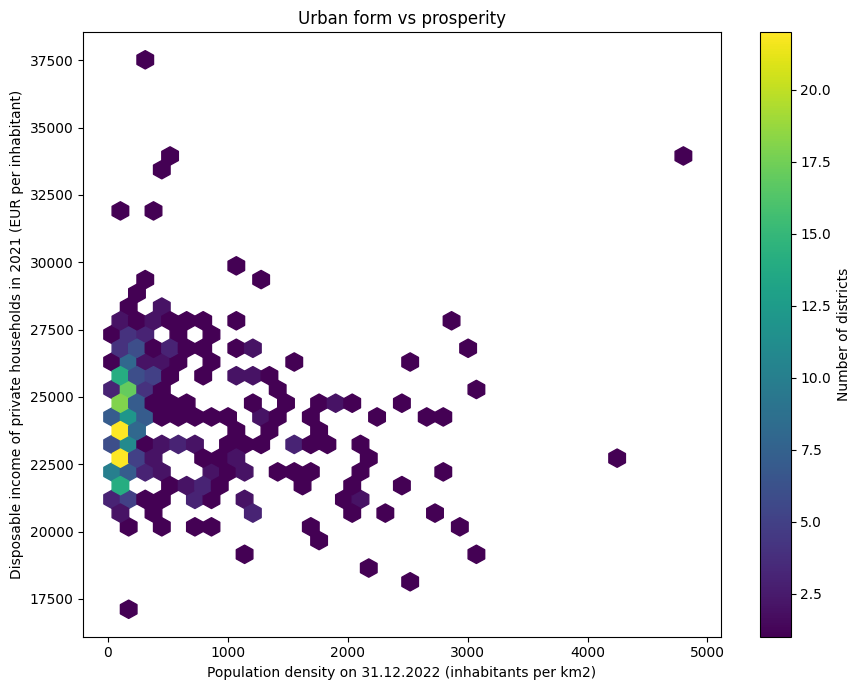

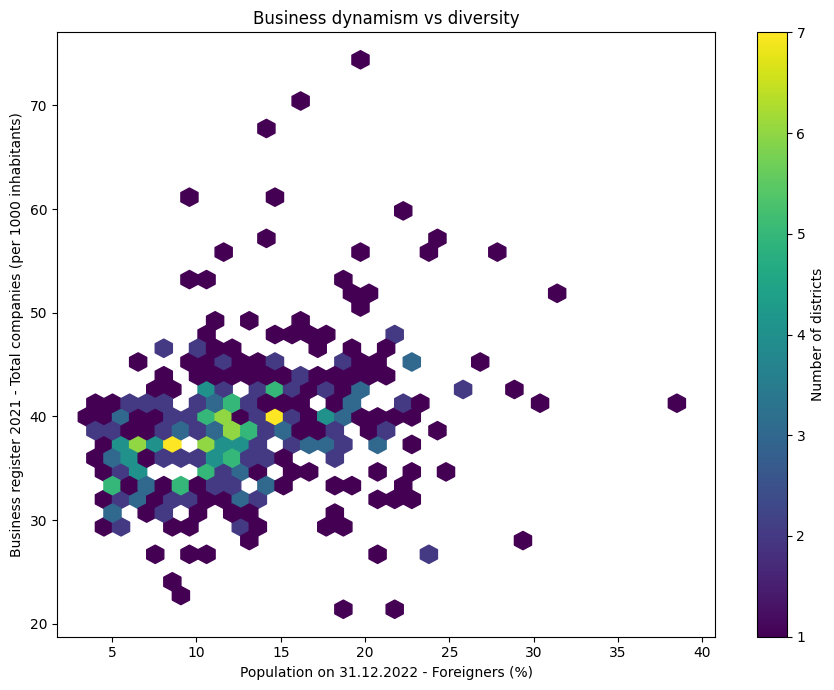

Population density on 31.12.2022 (inhabitants per km2) vs Disposable income of private households in 2021 (EUR per inhabitant) — Pearson: -0.078, Spearman: 0.049
Population on 31.12.2022 - Foreigners (%) vs Business register 2021 - Total companies (per 1000 inhabitants) — Pearson: 0.279, Spearman: 0.326


In [20]:
# --- 1) Start from your cleaned master frame: idt_df ---
# assume you already created idt_df['district_length'] as in your code
mode_len = idt_df['district_length'].mode().iat[0]
unusual_length_threshold = 1
mask_len = (idt_df['district_length'] - mode_len).abs() <= unusual_length_threshold

# This is the dataset you'll use everywhere below
dist_df = idt_df.loc[mask_len].copy()

# --- 2) Column locators (edit keywords if your headers differ) ---
def pick(df, *keywords):
    for c in df.columns:
        name = c.lower()
        if all(k.lower() in name for k in keywords):
            return c
    raise KeyError(f"No column found for keywords: {keywords}")

density_col    = pick(dist_df, "density")                        # e.g. "Population density (inhabitants per km2)"
income_col     = pick(dist_df, "disposable", "income")           # e.g. "Disposable income …"
foreigners_col = pick(dist_df, "foreign")                        # e.g. "Population – Foreigners (%)"
companies_col  = pick(dist_df, "business register", "per 1000")  # e.g. "… Total companies (per 1000 inhabitants)"

# --- 3) Ensure numeric + drop missing rows only for needed vars ---
need = [density_col, income_col, foreigners_col, companies_col]
for c in need:
    dist_df[c] = pd.to_numeric(dist_df[c], errors="coerce")
dist_df = dist_df.dropna(subset=need)

# --- 4) Plot helpers (reuse same cleaned dist_df) ---
def hexbin_xy(df, x, y, title):
    fig, ax = plt.subplots(figsize=(9,7))
    hb = ax.hexbin(df[x], df[y], gridsize=35, mincnt=1, cmap='viridis')
    fig.colorbar(hb, ax=ax, label="Number of districts")
    ax.set_xlabel(x); ax.set_ylabel(y); ax.set_title(title)
    plt.tight_layout(); plt.show()

# Urban form vs prosperity
hexbin_xy(dist_df, density_col, income_col, "Urban form vs prosperity")

# Business dynamism vs diversity
hexbin_xy(dist_df, foreigners_col, companies_col, "Business dynamism vs diversity")

# --- 5) Quick correlation check (optional) ---
for x, y in [(density_col, income_col), (foreigners_col, companies_col)]:
    pear = dist_df[[x,y]].corr(method="pearson").iloc[0,1]
    spear = dist_df[[x,y]].corr(method="spearman").iloc[0,1]
    print(f"{x} vs {y} — Pearson: {pear:.3f}, Spearman: {spear:.3f}")


## Business dynamism vs diversity.
Clear but modest positive association: bins are densest around ~8–15% foreigners and ~35–42 firms/1k, with a tail toward more firms as diversity rises. Variance grows at higher diversity → relationship is real but not strong.

## Urban form vs prosperity.
No robust “urban premium” in district-level terms. Density is extremely right-skewed and most observations are low-density districts with €21–26k incomes; a few very dense cities don’t shift the picture. That’s why your mean looks lower than expected: you’re using an unweighted district mean, while national figures are usually population-weighted (cities carry far more people but count as just one row here).

Using hexbins to reduce overplotting, we find a weak but positive association between district diversity and business density, with greater variance at higher diversity levels. For density versus income, the mass of districts sits at low densities with mid incomes and a few very dense cities; at the district level this yields no robust urban-income premium. Because hexbins count districts, not people, unweighted means skew low; population-weighted summaries (and a log-scaled density axis) are recommended as robustness checks.

## 3.4 Recipients of Social Welfare (SGB II)  

SGB II recipients indicate the extent of welfare dependency within a district. This measure captures structural socio-economic vulnerability and has been a central point of political debate.  
Welfare reliance has historically been politicized by different parties: SPD, Greens, and Left emphasize social support, CDU/CSU and FDP argue for stricter conditionality, and AfD has capitalized on welfare debates by linking them to migration issues (Hohmeyer & Lietzmann, 2019; Dostal, 2017).  

The descriptive analysis here proceeds in three steps:  

1. **Summary statistics** — provide an overview of the central tendency and spread of SGB II recipients across the 400 districts.  
2. **Choropleth map** — visualize geographic variation in welfare dependency, expected to highlight higher reliance in eastern Germany and post-industrial regions.  
3. **Scatterplot (SGB II vs. Share of Foreign Residents)** — examine the relationship between welfare dependency and demographic diversity.  
   This scatterplot is useful because it moves beyond simple spatial description and asks whether districts with higher foreign population shares also exhibit systematically higher welfare reliance — a politically sensitive linkage in German electoral debates.  

Together, these views illustrate both the geographic clustering of welfare dependency and its potential demographic correlates, offering insights into structural divides with strong electoral implications.


Summary statistics for Recipients of benefits under SGB II in August 2023 - total (per 1000 inhabitants)
count    400.00
mean      60.27
std       30.38
min       16.40
25%       38.78
50%       53.65
75%       74.62
max      205.30
Name: Recipients of benefits under SGB II in August 2023 - total (per 1000 inhabitants), dtype: float64


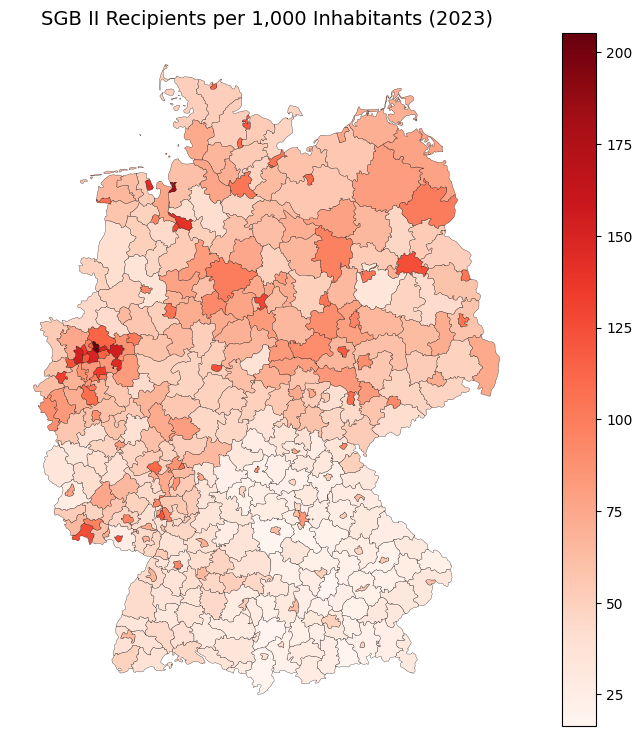

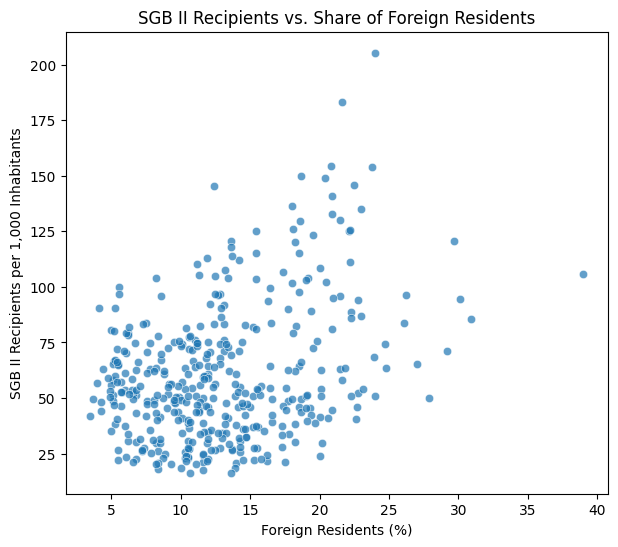

In [ ]:
# Column names (adjust if necessary)
sgb_col = "Recipients of benefits under SGB II in August 2023 - total (per 1000 inhabitants)"
foreign_col = "Population on 31.12.2022 - Foreigners (%)"
label_col = "Name"

# --- 1. Summary statistics ---
print("Summary statistics for", sgb_col)
print(dist_df[sgb_col].describe().round(2))

# --- 2. Choropleth map ---
if sgb_col in geo_df.columns:
    ax = geo_df.plot(
        column=sgb_col,
        cmap="Reds",
        legend=True,
        figsize=(10, 9),
        edgecolor="black",
        linewidth=0.2,
        missing_kwds={"color": "lightgrey", "label": "No data"},
    )
    ax.set_title("SGB II Recipients per 1,000 Inhabitants (2023)", fontsize=14)
    ax.set_axis_off()
    plt.show()
else:
    print(f"Column '{sgb_col}' not found in geo_df. Did you merge correctly?")

# --- 3. Scatterplot: SGB II vs. Share of Foreign Residents ---
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=dist_df,
    x=foreign_col,
    y=sgb_col,
    alpha=0.7
)
plt.title("SGB II Recipients vs. Share of Foreign Residents")
plt.xlabel("Foreign Residents (%)")
plt.ylabel("SGB II Recipients per 1,000 Inhabitants")
plt.show()


**3.3 Interpretation — SGB II Recipients**

On average, districts report around 60 SGB II recipients per 1,000 inhabitants, with a median of 54. The distribution is fairly wide (std ≈ 30), ranging from 16 in the lowest districts to more than 200 in the most deprived. The choropleth map reveals a clear **geographic clustering**: welfare dependency is highest in eastern Germany, the Ruhrgebiet, and certain northern cities such as Bremen and Bremerhaven. In contrast, prosperous Bavarian and southern districts record consistently low rates of SGB II reliance.  

The scatterplot comparing SGB II recipients with the share of foreign residents shows a **positive association**: districts with larger foreign populations often also record higher levels of welfare dependency. This pattern should not be overstated — there is wide variation, and many diverse urban districts still fall close to the average — but it does illustrate how welfare and migration debates intersect spatially.  

This descriptive evidence resonates strongly with prior research. Hohmeyer & Lietzmann (2019) and Dostal (2017) emphasize that welfare dependency has been central to partisan conflict, with SPD, Greens, and Left advocating stronger support, while CDU/CSU and FDP push for stricter conditionality. The AfD in particular has politicized the perceived link between migration and welfare, often pointing to districts with both high foreign shares and elevated benefit dependency as evidence of strain on the welfare state.  

Thus, the geography of SGB II reliance reflects both **socio-economic divides** (prosperous south vs. struggling east and Ruhrgebiet) and **demographic dynamics** (higher foreign population shares in some welfare-dependent districts). These structural patterns align with electoral cleavages: welfare-heavy, diverse urban centers become contested terrain between SPD/Greens and AfD, while low-welfare, affluent rural districts remain strongholds of CDU/CSU or FDP.

*Note:*  
The dataset also contains a variable for **SGB II recipients who are foreign residents**.  
For this analysis, however, we focus on the **overall number of SGB II recipients per 1,000 inhabitants**.  
This choice ensures that we capture the **broader structural extent of welfare dependency** in each district, rather than restricting attention to a single subgroup.  
By doing so, we avoid narrowing the descriptive picture and can later examine how welfare dependency and demographic diversity (e.g., share of foreign residents) interact — as illustrated in the scatterplot.  
The subgroup variable remains analytically relevant but will be treated as an extension rather than the primary focus.



## 3.4 Business Activity

**The density of registered companies relative to the population size** in each district reflects levels of **entrepreneurial activity, service-sector development, and local business dynamism**. High values are typically found in urban, service-oriented, or tourism-heavy regions, while low values are more common in rural or structurally weaker areas that depend on a few large employers or agriculture.  

From a political perspective, this indicator links to broader modernization divides. Research shows that **service-oriented and economically dynamic regions** tend to support progressive or pro-business parties (SPD, Greens, FDP), while **areas with fewer companies per capita and more traditional economic structures** are often more aligned with conservative or populist parties (CDU/CSU, AfD) (Kowalewski, 2010, 2011).  

The descriptive analysis here will therefore provide insight into how patterns of business density vary across districts, highlighting both geographic contrasts and their potential relevance for electoral competition.


Summary statistics — Business register 2021 - Total companies (per 1000 inhabitants)
count    400.00
mean      38.92
std        6.56
min       21.40
25%       35.38
50%       38.35
75%       41.52
max       74.40
Name: Business register 2021 - Total companies (per 1000 inhabitants), dtype: float64


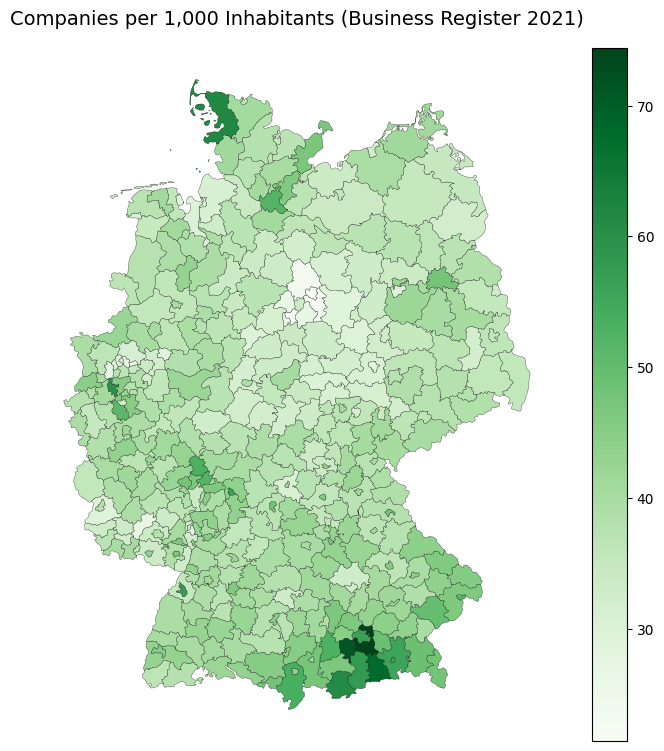

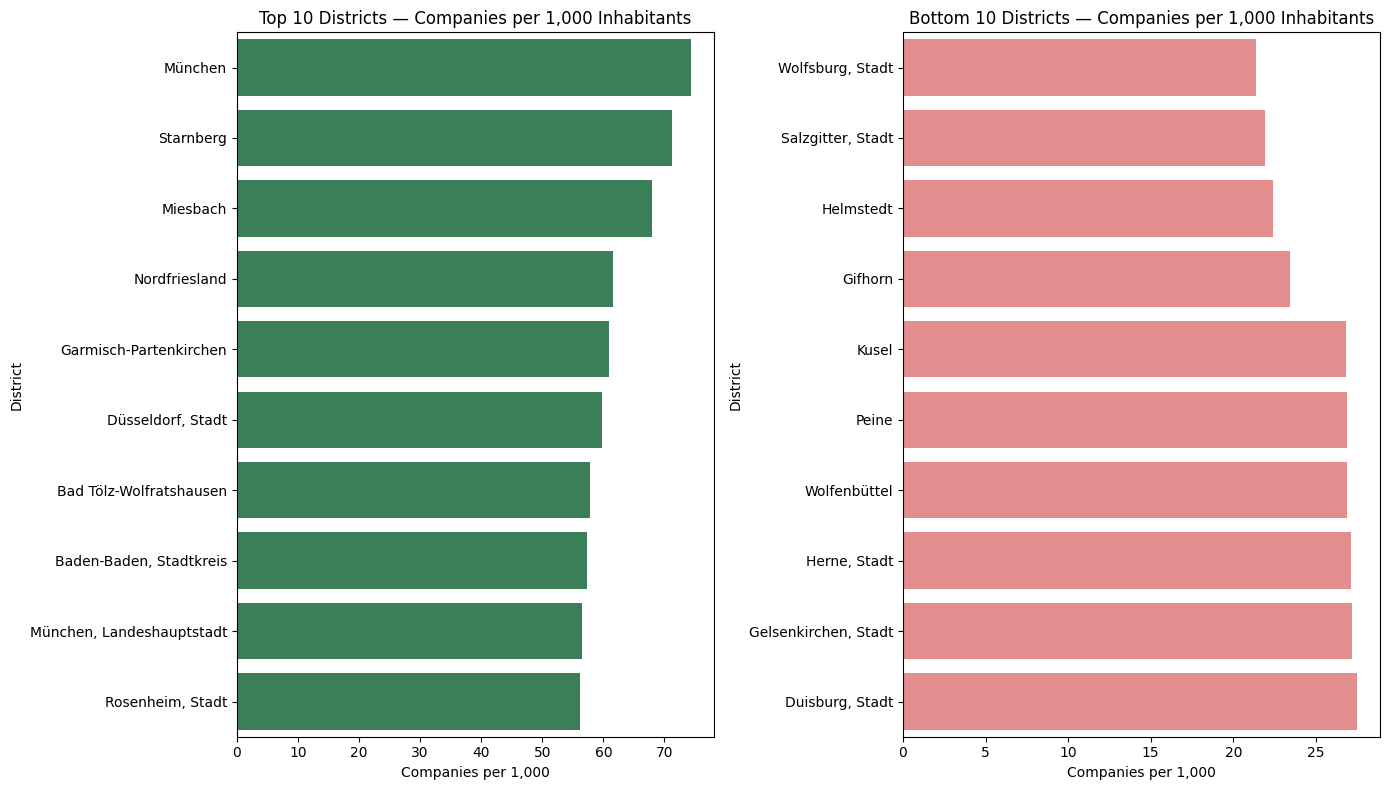

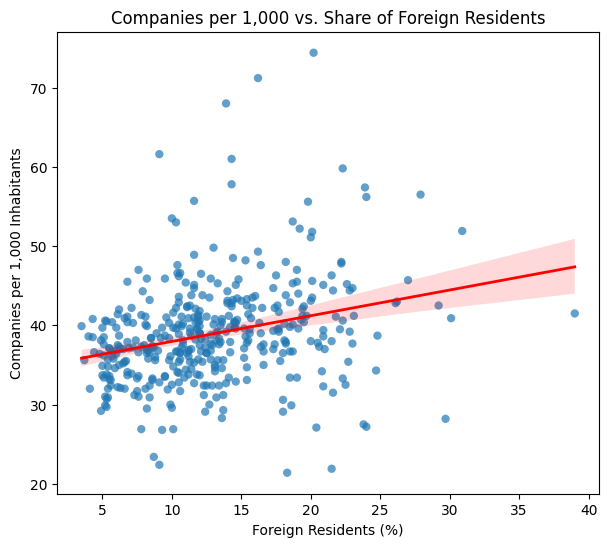

Pearson r between Population on 31.12.2022 - Foreigners (%) and Business register 2021 - Total companies (per 1000 inhabitants): 0.279


In [ ]:
# --- Column names (adjust if yours differ) ---
biz_col     = "Business register 2021 - Total companies (per 1000 inhabitants)"
foreign_col = "Population on 31.12.2022 - Foreigners (%)"
label_col   = "Name"

# Ensure numeric types (safe no-ops if already numeric)
for c in [biz_col, foreign_col]:
    if dist_df[c].dtype == "object":
        dist_df[c] = (
            dist_df[c].astype(str)
            .str.replace("%", "", regex=False)
            .str.replace(",", ".", regex=False)
            .str.strip()
        )
        dist_df[c] = pd.to_numeric(dist_df[c], errors="coerce")

# --- 1) Summary statistics ---
print("Summary statistics —", biz_col)
print(dist_df[biz_col].describe().round(2))

# --- 2) Choropleth map ---
if biz_col in geo_df.columns:
    ax = geo_df.plot(
        column=biz_col,
        cmap="Greens",
        legend=True,
        figsize=(10, 9),
        edgecolor="black",
        linewidth=0.2,
        missing_kwds={"color": "lightgrey", "label": "No data"},
    )
    ax.set_title("Companies per 1,000 Inhabitants (Business Register 2021)", fontsize=14)
    ax.set_axis_off()
    plt.show()
else:
    print(f"Column '{biz_col}' not found in geo_df. Did you merge dist_df with the shapefile into geo_df?")

# --- 3) Ranked barplots (Top 10 & Bottom 10 by business density) ---
top10 = dist_df.nlargest(10, biz_col).copy()
bot10 = dist_df.nsmallest(10, biz_col).copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharex=False)

sns.barplot(y=label_col, x=biz_col, data=top10, ax=axes[0], color="seagreen")
axes[0].set_title("Top 10 Districts — Companies per 1,000 Inhabitants")
axes[0].set_xlabel("Companies per 1,000")
axes[0].set_ylabel("District")

sns.barplot(y=label_col, x=biz_col, data=bot10, ax=axes[1], color="lightcoral")
axes[1].set_title("Bottom 10 Districts — Companies per 1,000 Inhabitants")
axes[1].set_xlabel("Companies per 1,000")
axes[1].set_ylabel("District")

plt.tight_layout()
plt.show()

# --- 4) Relationship: Business density vs. % Foreign (scatter + trend line) ---
plt.figure(figsize=(7,6))
sns.regplot(
    data=dist_df,
    x=foreign_col, y=biz_col,
    scatter_kws={'alpha':0.7, 'edgecolor': 'none'},
    line_kws={'color':'red', 'linewidth':2}
)
plt.title("Companies per 1,000 vs. Share of Foreign Residents")
plt.xlabel("Foreign Residents (%)")
plt.ylabel("Companies per 1,000 Inhabitants")
plt.show()

# Pearson correlation (quick read on direction/strength)
r = dist_df[[foreign_col, biz_col]].corr().iloc[0,1]
print(f"Pearson r between {foreign_col} and {biz_col}: {r:.3f}")


**3.4 Interpretation — Business Activity**

On average, districts register about 39 companies per 1,000 inhabitants, with values ranging from around 21 in structurally weaker areas to more than 74 in highly dynamic regions. The distribution is relatively narrow compared to other indicators, but the choropleth map shows clear **regional clustering**. The south of Germany, particularly Bavaria (e.g., Munich, Starnberg, Miesbach), and certain urban or tourism-driven areas such as Düsseldorf or Baden-Baden, record the highest business densities. In contrast, post-industrial districts in Lower Saxony and North Rhine-Westphalia, including Duisburg, Gelsenkirchen, and Wolfsburg, are among those with the fewest companies per capita.  

The scatterplot reveals a **positive association between company density and the share of foreign residents**. Districts with higher percentages of foreigners also tend to have more companies per 1,000 inhabitants. This reflects the fact that economically dynamic and diverse urban areas are simultaneously centers of **entrepreneurship and migration**.  

Taken together, these results reinforce a dual narrative. On the one hand, **rural and post-industrial districts with weaker business structures** remain aligned with traditional or populist political preferences. On the other, **cosmopolitan urban economies with high business dynamism and greater diversity** form strongholds for progressive or pro-market parties (SPD, Greens, FDP), consistent with the modernization divide highlighted in previous research (Kowalewski, 2010, 2011). The descriptive evidence thus underlines how entrepreneurship and diversity are intertwined in shaping the electoral geography of Germany.  

It would be interesting to compare how business dynamism vs diversity acros germany

## 3.6 Step 3 — Descriptive Analysis — Conclusion

In Step 3, we conducted descriptive analyses of four structural indicators: **population density, share of foreign residents, disposable income, and business activity**.  
Each of these dimensions was chosen to illustrate distinct structural divides across German districts and to link them to electoral cleavages discussed in the literature.  

- **Population density** highlighted the urban–rural divide, with densely populated metropolitan districts contrasting sharply with sparsely populated rural regions.  
- **Share of foreign residents** revealed demographic diversity concentrated in western and southern cities, while eastern districts remained comparatively homogeneous.  
- **Disposable income** showed enduring economic inequalities, with prosperous southern districts diverging from structurally weaker areas in the Ruhrgebiet and eastern Germany.  
- **Business activity** demonstrated that entrepreneurial dynamism and service-sector growth cluster in diverse, urban economies, while post-industrial and rural regions lag behind.  

Together, these indicators reveal consistent patterns of **structural polarization**: dynamic, prosperous, and diverse urban districts stand in contrast to rural, post-industrial, and economically vulnerable areas.  
These divides are not only socio-economic and demographic in nature, but also closely tied to electoral behavior, as suggested by the literature.  

## 4. Conclusion  

The purpose of this assignment was to conduct a **thorough descriptive analysis at the district level** using structural data provided by the Statistische Ämter des Bundes und der Länder.   
We began by preparing and validating the dataset to ensure it matched the official count of 400 districts. This preparation involved removing aggregate rows, converting variables into numeric formats and standardizing percentages.

In the descriptive analysis, we focused on a **core set of indicators** that the political science literature consistently highlights as important drivers of electoral outcomes:  
- **Population density** (urban–rural divide),  
- **Share of foreign residents** (migration and diversity),  
- **Disposable income** (prosperity and inequality),  
- **Recipients of social welfare (SGB II)** (socio-economic vulnerability), and  
- **Business activity (companies per 1,000 inhabitants)** (entrepreneurship and modernization).  

This selection necessarily meant that **other available variables were not analyzed in detail**.  
The indicators chosen do not represent the only or even the most emphasized factors in the literature.  
For example, education — an important driver of electoral behavior — was not included in our descriptive analysis.  
Instead, the selected indicators reflect a combination of theoretical relevance and the particular analytical interests of the authors.  
The aim was to cover a diverse set of structural dimensions while keeping the scope of the assignment manageable.

Where appropriate, we complemented descriptive distributions and maps with **correlation analysis** to explore structural relationships (e.g., between foreign residents and welfare dependency, or between diversity and business activity). These results should be understood strictly as **correlations**: they do not imply causality. Other omitted variables — such as housing markets, age structures, or regional policy interventions — may better explain some of the observed trends.  

Overall, our analysis highlights persistent structural divides across German districts:  
- Prosperous, diverse, and entrepreneurial urban regions contrast with  
- Rural, post-industrial, or economically vulnerable areas.  

These divides align with electoral cleavages described in the literature, but future work would need to integrate more variables and employ causal methods to fully capture the complexity of Germany’s electoral geography.  

---

## Bibliography  

- Batool, I. (2008). Bread, peace and the attrition of power: Economic events and German election results.

- Batool, I., & Sieg, G. (2009). Bread and the attrition of power: Economic events and German election results. *Public Choice, 141*(1–2), 151–165. https://doi.org/10.1007/s11127-009-9443-x  

- Dorn, F., Fuest, C., Immel, L., & Neumeier, F. (2018). Inequality and extremist voting: Evidence from Germany.  

- Dostal, J. (2017). The German federal election of 2017: How the wedge issue of refugees and migration took the shine off Chancellor Merkel and transformed the party system. *The Political Quarterly, 88*(4), 589–602. https://doi.org/10.1111/1467-923x.12445  

- Haffert, L., & Mitteregger, R. (2023). Cohorts and neighbors: Urban–rural conflict along the age gradient. *Electoral Studies, 85,* 102705. https://doi.org/10.1016/j.electstud.2023.102705  

- Hohmeyer, K., & Lietzmann, T. (2019). Persistence of welfare receipt and unemployment in Germany: Determinants and duration dependence. *Journal of Social Policy, 49*(2), 299–322. https://doi.org/10.1017/S0047279419000242  

- Kellermann, K., & Winter, S. (2021). Immigration and anti-immigrant voting in the 2017 German parliamentary election. *German Economic Review, 23*(3), 341–401. https://doi.org/10.1515/ger-2021-0026  

- Kowalewski, J. (2010). Specialisation and employment development in Germany: Analysis at regional level.

- Kowalewski, J. (2011). Specialization and employment development in Germany: An analysis at the regional level. *Jahrbücher für Nationalökonomie und Statistik, 231*(6), 789–811. https://doi.org/10.1111/j.1435-5957.2011.00355.x  

- Otto, A., & Steinhardt, M. (2014). Immigration and election outcomes—Evidence from city districts in Hamburg. *Regional Science and Urban Economics, 45,* 67–79. https://doi.org/10.1016/j.regsciurbeco.2014.01.004  

- Schmitt-Beck, R., Roßteutscher, S., Schoen, H., Weßels, B., & Wolf, C. (2022). *The changing German voter* (p. 416). Oxford University Press. https://doi.org/10.1093/oso/9780198864514.001.0001
